<a href="https://colab.research.google.com/github/BrouthenKamel/HAICK-2023/blob/main/Sonatrach_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
from tensorflow import keras as keras
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
import seaborn as sns

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [3]:
data_path = '/gdrive/MyDrive/Sonatrach_Dataset'

In [4]:
data_sample = pd.read_csv(data_path+'/sample.csv')
data_train = pd.read_csv(data_path+'/train_dataset.csv')
data_test = pd.read_csv(data_path+'/test_dataset.csv')

In [5]:
target_col = "ROP (Time)"

<AxesSubplot:>

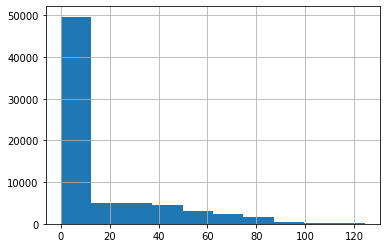

In [6]:
data_train[target_col].hist()

Testing with XGBOOST

In [7]:
X = data_train.drop(columns = [target_col])
y = data_train[target_col]

In [24]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

xgb_reg = XGBRegressor()

params = {'max_depth': [15],
          'learning_rate': [0.1],
          'n_estimators': [500]}

grid_search = GridSearchCV(estimator=xgb_reg, param_grid=params, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_estimator = grid_search.best_estimator_

print(grid_search.best_params_)

print(grid_search.best_estimator_)

y_pred = best_estimator.predict(X_test)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE:", rmse)

[14:59:05] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 500}
XGBRegressor(max_depth=15, n_estimators=500)
RMSE: 3.427715934491912


In [26]:
data_pred = best_estimator.predict(data_test)

submission = dict()
submission["id"] = []
submission["ROP (Time)"] = []

for index, row in enumerate(data_pred):
  submission["id"].append(index)
  submission["ROP (Time)"].append(row)

submit = pd.DataFrame(submission)
submit.head()

submit.to_csv('/content/xgboost_00.csv', index=False)

<AxesSubplot:>

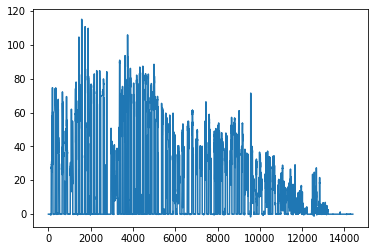

In [27]:
submit["ROP (Time)"].plot()

<AxesSubplot:>

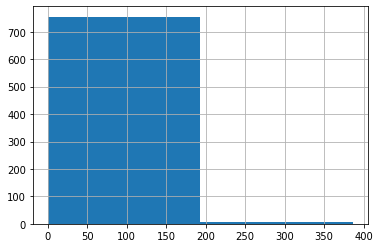

In [29]:
data_train[data_train[target_col] != 0][target_col].value_counts().hist(bins=2)

In [30]:
data_train["is_penetratable"] = data_train['ROP (Time)'] != 0

In [31]:
data_train["is_penetratable"] = data_train["is_penetratable"].replace({True:1, False:0})

In [32]:
data_train["is_penetratable"]

0        0
1        0
2        0
3        0
4        0
        ..
71995    0
71996    0
71997    0
71998    0
71999    0
Name: is_penetratable, Length: 72000, dtype: int64

<AxesSubplot:>

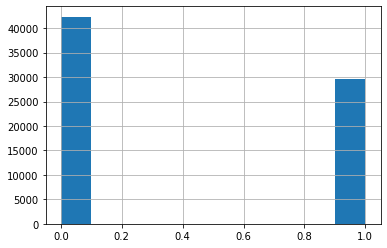

In [33]:
data_train["is_penetratable"].hist()

In [34]:
X_classif = data_train.drop(columns = ["is_penetratable", 'ROP (Time)'])
y_classif = data_train["is_penetratable"]

In [35]:
from sklearn.feature_selection import mutual_info_classif

def make_mi_scores(X, y):
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [36]:
mi_scores = make_mi_scores(X_classif, y_classif)

In [37]:
mi_scores[mi_scores > 0.5].index

Index(['Depth: TMD', 'WOB Max', 'WOB Avg', 'RPM Avg', 'Torque Avg', 'RPM Inst',
       'Torque Max', 'Torque Min'],
      dtype='object')

In [38]:
features_classif = ['Depth: TMD', 'WOB Max', 'WOB Avg', 'RPM Avg', 'Torque Avg', 'RPM Inst',
       'Torque Max', 'Torque Min']

In [39]:
X_classif = X_classif[features_classif]

In [40]:
# Import necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, recall_score, precision_score

# Split the X and y data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_classif, y_classif, test_size=0.2, random_state=42)

# Standardize the X data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create a logistic regression classifier
clf = LogisticRegression()

# Define the parameter grid to search over
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

# Create a grid search object with the logistic regression classifier and the parameter grid
grid_search = GridSearchCV(clf, param_grid, cv=3)

# Fit the grid search object on the standardized training data
grid_search.fit(X_train_scaled, y_train)

# Get the best hyperparameters from the grid search
best_params = grid_search.best_params_

# Use the best hyperparameters to create a new logistic regression classifier
best_clf = LogisticRegression(penalty=best_params['penalty'],
                              C=best_params['C'],
                              solver=best_params['solver'])

# Fit the new classifier on the standardized training data
best_clf.fit(X_train_scaled, y_train)

# Predict on the standardized testing data
y_pred = best_clf.predict(X_test_scaled)

print(best_params)

# Calculate the accuracy, recall, and precision on the standardized testing data using the new classifier
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"accuracy = {accuracy} , recall = {recall} , precision = {precision}")

{'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
accuracy = 0.9698611111111111 , recall = 0.9811669749453505 , precision = 0.9477018028260517


In [41]:
from xgboost import XGBClassifier

xgb_cls = XGBClassifier()

# Define hyperparameter grid for grid search
params = {'max_depth': [10, 15],
          'learning_rate': [0.1],
          'n_estimators': [ 100, 200],
          'gamma': [0.1, 0.2]}

grid_search = GridSearchCV(estimator=xgb_cls, param_grid=params, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get best estimator from grid search
best_estimator = grid_search.best_estimator_

print(grid_search.best_estimator_, grid_search.best_params_)

# Make predictions on test set
y_pred = best_estimator.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)

print(f"accuracy = {accuracy} , recall = {recall} , precision = {precision}")

XGBClassifier(gamma=0.1, max_depth=15, n_estimators=200) {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 200}
accuracy = 0.9908333333333333 , recall = 0.9926013115856734 , precision = 0.985311300283759


<AxesSubplot:>

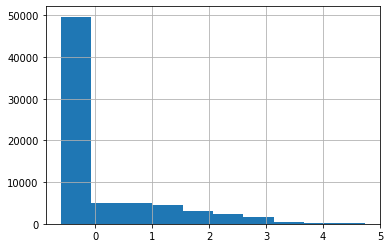

In [91]:
scaler_target = StandardScaler()

data_train[target_col] = scaler_target.fit_transform(data_train[target_col].to_numpy().reshape(-1, 1))

data_train[target_col].hist()

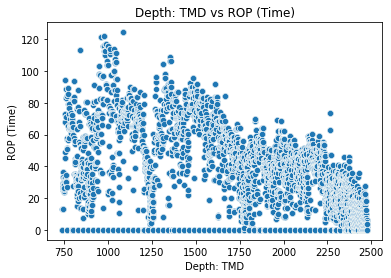

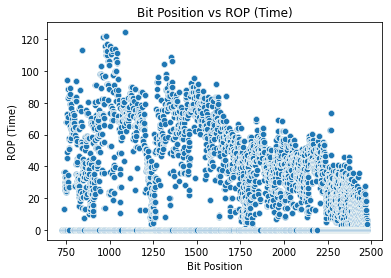

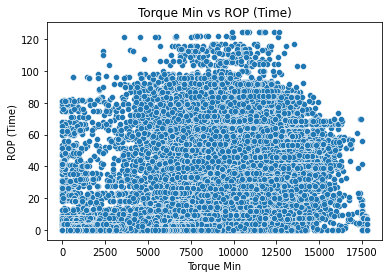

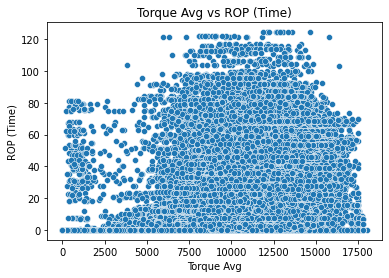

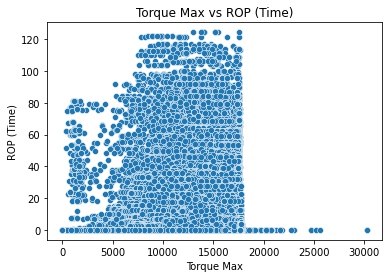

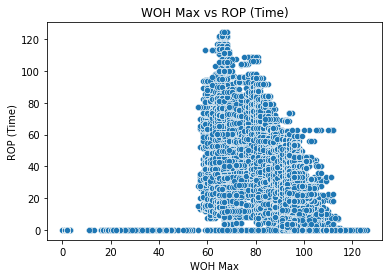

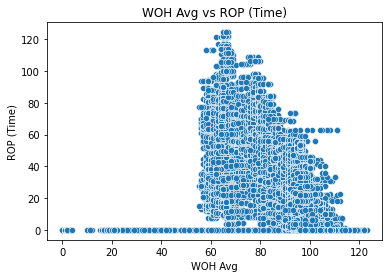

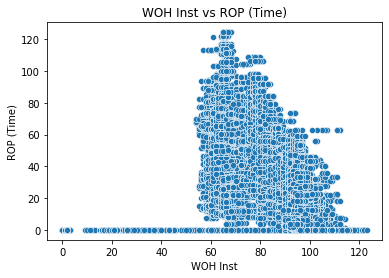

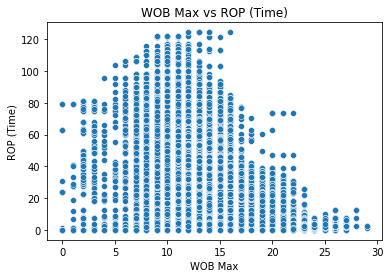

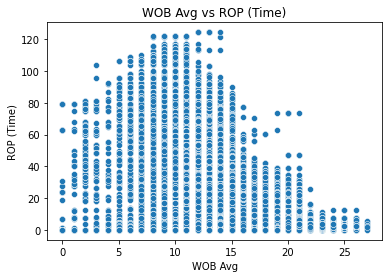

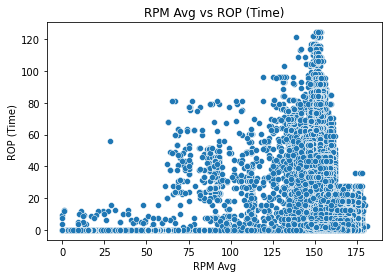

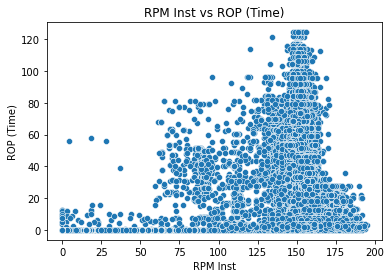

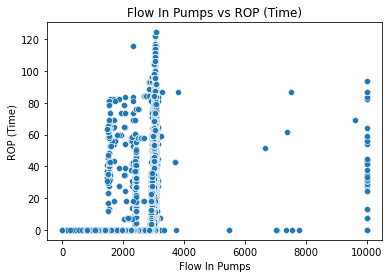

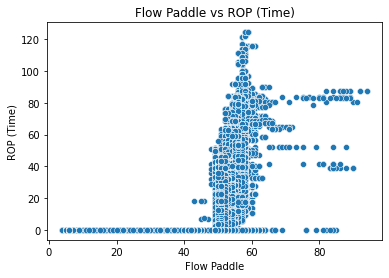

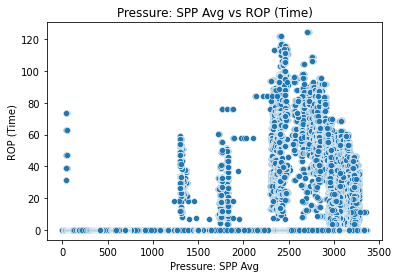

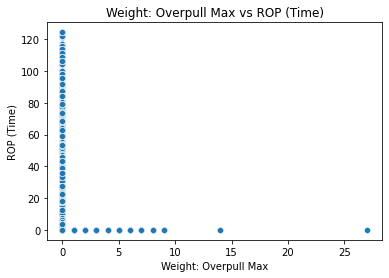

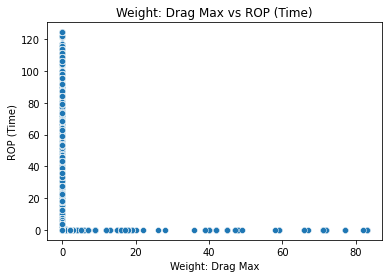

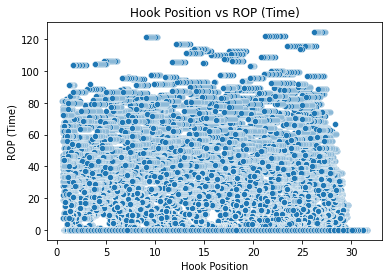

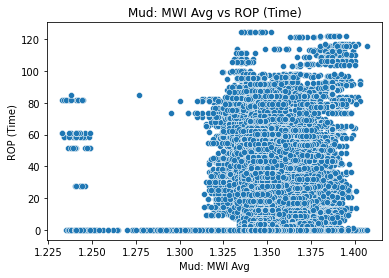

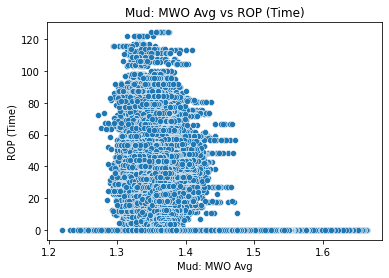

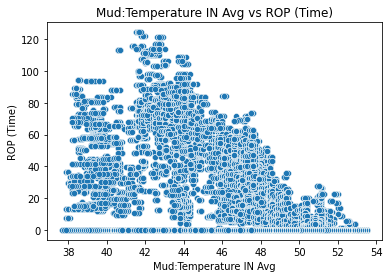

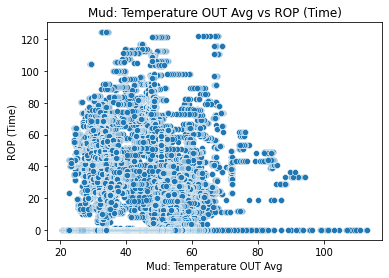

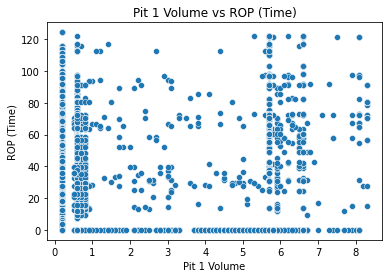

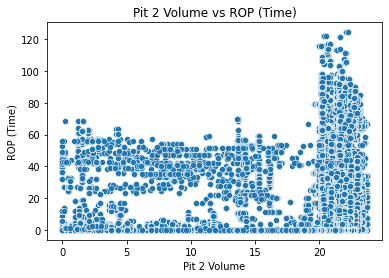

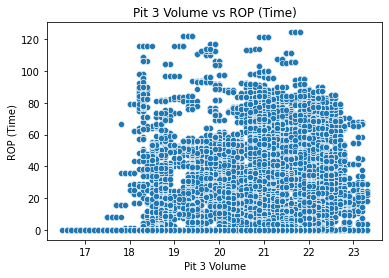

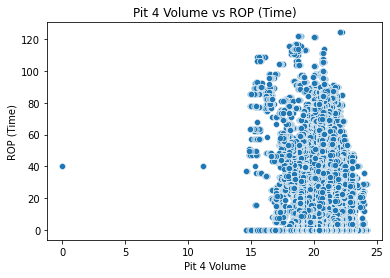

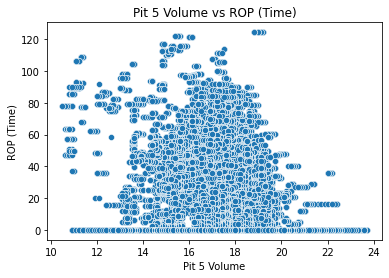

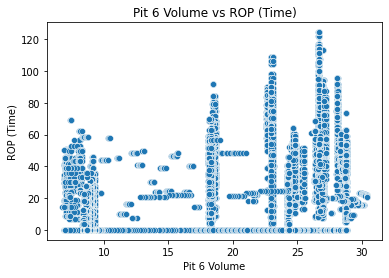

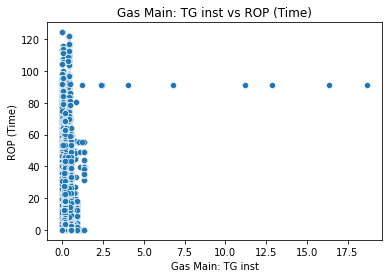

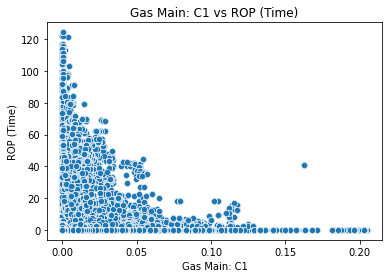

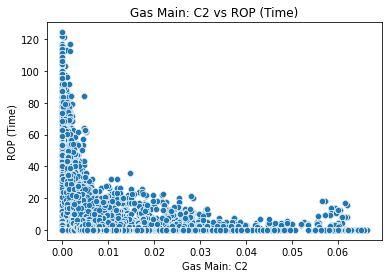

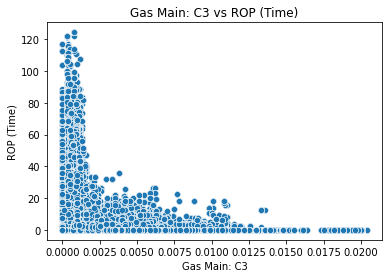

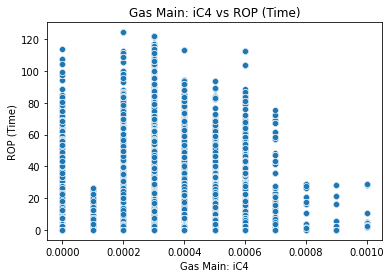

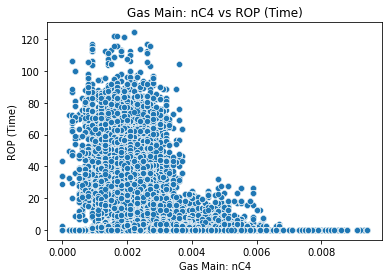

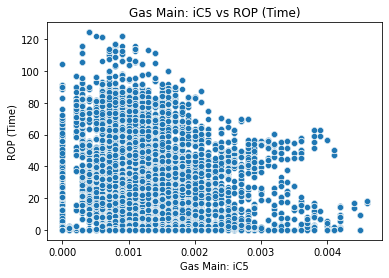

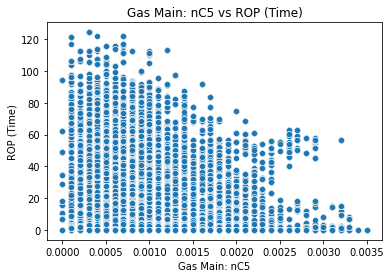

In [53]:
for col in data_train.columns:
    if col != target_col:
        plt.figure()
        sns.scatterplot(x=col, y=target_col, data=data_train)
        plt.xlabel(col)
        plt.ylabel(target_col)
        plt.title(f'{col} vs {target_col}')
        plt.show()

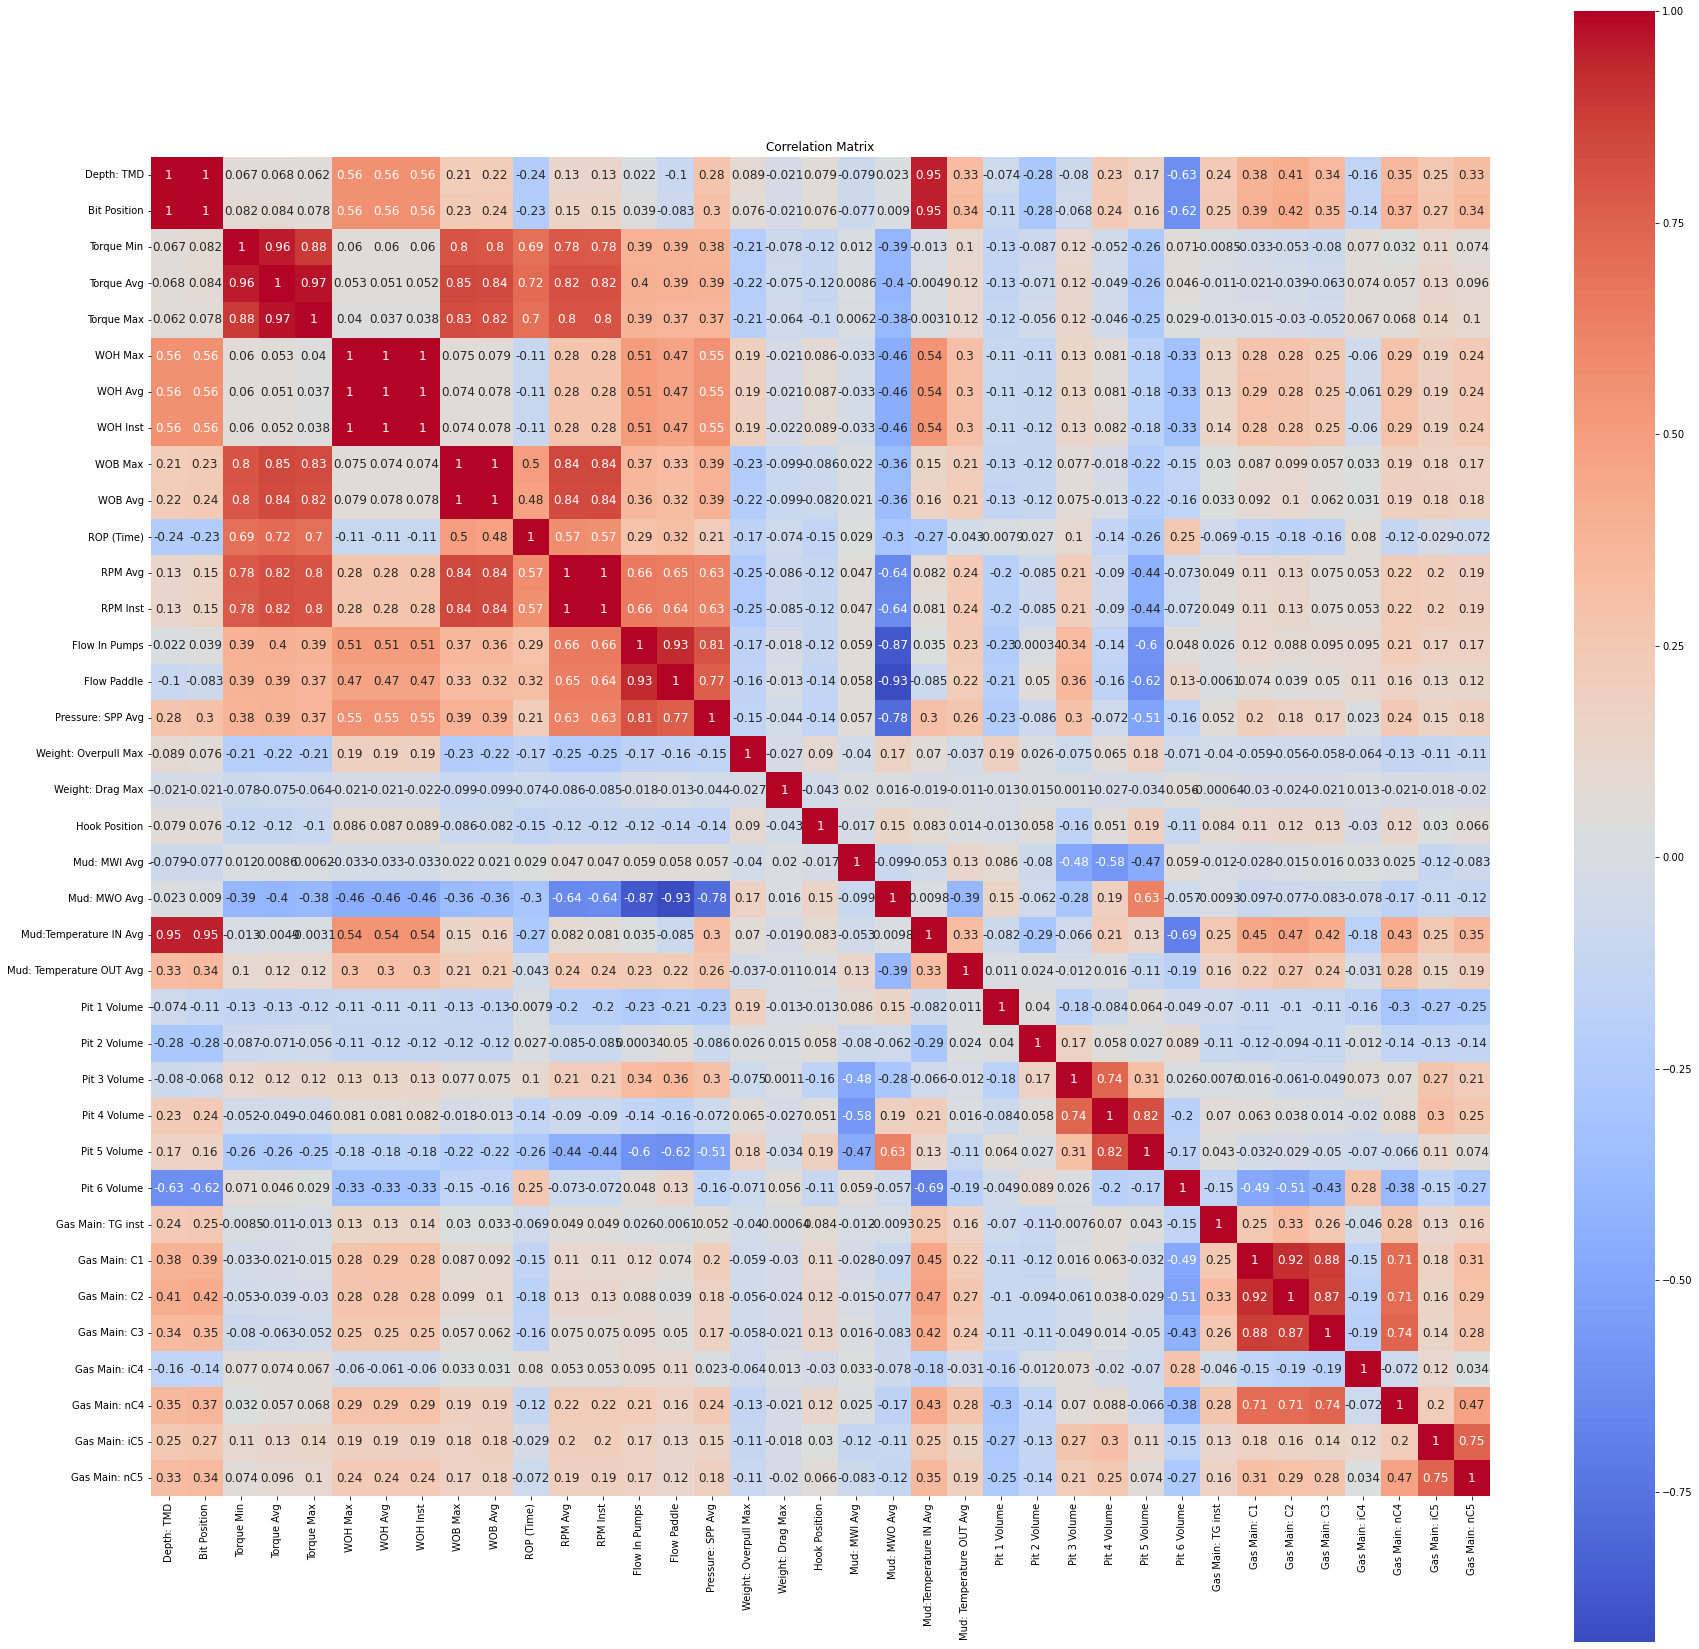

In [54]:
corr = data_train.corr()

fig, ax = plt.subplots(figsize=(30,30))
sns.heatmap(corr, cmap='coolwarm', annot=True, annot_kws={'size': 12}, square=True)

plt.title('Correlation Matrix')
plt.show()

In [55]:
corr[target_col][ (corr[target_col] > 0.1) | (corr[target_col] < -0.1)].index

Index(['Depth: TMD', 'Bit Position', 'Torque Min', 'Torque Avg', 'Torque Max',
       'WOH Max', 'WOH Avg', 'WOH Inst', 'WOB Max', 'WOB Avg', 'ROP (Time)',
       'RPM Avg', 'RPM Inst', 'Flow In Pumps', 'Flow Paddle',
       'Pressure: SPP Avg', 'Weight: Overpull Max', 'Hook Position',
       'Mud: MWO Avg', 'Mud:Temperature IN Avg', 'Pit 3 Volume',
       'Pit 4 Volume', 'Pit 5 Volume', 'Pit 6 Volume', 'Gas Main: C1',
       'Gas Main: C2', 'Gas Main: C3', 'Gas Main: nC4'],
      dtype='object')

In [56]:
lin_correlated = ['Depth: TMD', 'Bit Position', 'Torque Min', 'Torque Avg', 'Torque Max',
       'WOH Max', 'WOH Avg', 'WOH Inst', 'WOB Max', 'WOB Avg', 'ROP (Time)',
       'RPM Avg', 'RPM Inst', 'Flow In Pumps', 'Flow Paddle',
       'Pressure: SPP Avg', 'Weight: Overpull Max', 'Hook Position',
       'Mud: MWO Avg', 'Mud:Temperature IN Avg', 'Pit 3 Volume',
       'Pit 4 Volume', 'Pit 5 Volume', 'Pit 6 Volume', 'Gas Main: C1',
       'Gas Main: C2', 'Gas Main: C3', 'Gas Main: nC4']

In [57]:
#drop_cols = [ "Bit Position", "Torque Min", "WOH Inst", "WOH Max", "WOB Max", "Gas Main: C1", "Gas Main: C3", "Weight: Overpull Max", "Weight: Drag Max"]

In [58]:
#data_train.drop(columns = drop_cols, inplace = True)
#data_test.drop(columns = drop_cols, inplace = True)

In [59]:
def make_mi_scores(X, y):
    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [60]:
mi_scores = make_mi_scores(data_train.drop(columns = ["ROP (Time)"]), data_train["ROP (Time)"])
mi_scores[mi_scores > 0.5].index

Index(['Depth: TMD', 'Bit Position', 'Gas Main: C1', 'Flow In Pumps',
       'RPM Avg', 'Mud:Temperature IN Avg', 'Pressure: SPP Avg',
       'Pit 2 Volume', 'RPM Inst', 'WOB Avg', 'WOB Max', 'Hook Position',
       'Pit 5 Volume', 'Pit 6 Volume', 'Gas Main: C2', 'WOH Avg',
       'Gas Main: nC4', 'WOH Max', 'Pit 3 Volume', 'Pit 4 Volume',
       'Torque Max', 'WOH Inst', 'Torque Avg', 'Torque Min',
       'Mud: Temperature OUT Avg', 'Gas Main: C3', 'Gas Main: iC5',
       'Gas Main: nC5', 'Flow Paddle'],
      dtype='object')

In [61]:
useful_columns = ['Depth: TMD', 'Bit Position', 'Gas Main: C1', 'Flow In Pumps',
       'RPM Avg', 'Pressure: SPP Avg', 'Mud:Temperature IN Avg',
       'Pit 2 Volume', 'RPM Inst', 'WOB Avg', 'WOB Max', 'Hook Position',
       'Pit 5 Volume', 'Gas Main: C2', 'Pit 6 Volume', 'WOH Avg', 'WOH Max',
       'Gas Main: nC4', 'Pit 4 Volume', 'Pit 3 Volume', 'Torque Max',
       'WOH Inst', 'Torque Avg', 'Torque Min', 'Mud: Temperature OUT Avg',
       'Gas Main: C3', 'Gas Main: iC5', 'Gas Main: nC5', 'Flow Paddle']

In [62]:
use_cols = [ x for x in data_train.columns if x in lin_correlated and x in useful_columns ]

In [63]:
X = data_train.drop(columns = ["ROP (Time)"])
y = data_train["ROP (Time)"]

In [64]:
X = data_train[use_cols]
y = data_train["ROP (Time)"]

In [65]:
scalerX = StandardScaler()
X_standardized = scalerX.fit_transform(X)
X_standardized = pd.DataFrame(X_standardized, columns=X.columns)

In [66]:
scalery = StandardScaler()
y_standardized = scalery.fit_transform(y.values.reshape(-1, 1))
y_mean = scalery.mean_[0]
y_std = scalery.scale_[0]

In [67]:
pca = PCA(n_components=0.99)
X_pca = pca.fit_transform(X_standardized)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15
0,5.691051,-2.230181,0.713904,1.874938,-1.731874,1.590192,0.245705,0.326461,-0.437414,0.397715,0.665546,0.377380,0.581999,0.458177,0.247199
1,5.684569,-2.237094,0.700000,1.893046,-1.721267,1.596748,0.251476,0.328563,-0.436999,0.401316,0.661297,0.379862,0.576696,0.433049,0.241295
2,5.685463,-2.237053,0.700768,1.893113,-1.721077,1.596217,0.250304,0.327851,-0.437817,0.401413,0.659815,0.381880,0.576132,0.432639,0.240964
3,5.691287,-2.230098,0.714201,1.874912,-1.731736,1.590176,0.245508,0.326351,-0.437454,0.397706,0.665592,0.376917,0.581954,0.457826,0.247097
4,5.698653,-2.221716,0.733144,1.846024,-1.762575,1.599621,0.250628,0.317833,-0.434165,0.405667,0.664679,0.356633,0.569494,0.408870,0.233402


In [68]:
X_pca.shape

(72000, 15)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X_pca, y_standardized, test_size=0.2, random_state=20)

In [70]:
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

early_stop = EarlyStopping(monitor='val_loss', patience=3)

In [71]:
model = Sequential(
    [
    Dense(92, activation='relu', kernel_initializer='normal'),
     Dense(64, activation = 'relu', kernel_initializer='normal'),
     Dense(64, activation='relu', kernel_initializer='normal'),
     Dense(64, activation='relu', kernel_initializer='normal'),
    Dense(1, activation='linear', kernel_initializer='normal')
    ]
)

In [72]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=[rmse])

In [73]:
model.fit(X_train.to_numpy(), y_train, epochs=20 , validation_split=0.2)

Epoch 1/20
1440/1440 [==============================] - 6s 3ms/step - loss: 0.1900 - rmse: 0.4113 - val_loss: 0.1443 - val_rmse: 0.3655
Epoch 2/20
1440/1440 [==============================] - 4s 3ms/step - loss: 0.1399 - rmse: 0.3573 - val_loss: 0.1427 - val_rmse: 0.3626
Epoch 3/20
1440/1440 [==============================] - 6s 5ms/step - loss: 0.1301 - rmse: 0.3437 - val_loss: 0.1150 - val_rmse: 0.3244
Epoch 4/20
1440/1440 [==============================] - 4s 3ms/step - loss: 0.1233 - rmse: 0.3352 - val_loss: 0.1195 - val_rmse: 0.3306
Epoch 5/20
1440/1440 [==============================] - 5s 3ms/step - loss: 0.1162 - rmse: 0.3247 - val_loss: 0.1099 - val_rmse: 0.3149
Epoch 6/20
1440/1440 [==============================] - 7s 5ms/step - loss: 0.1105 - rmse: 0.3173 - val_loss: 0.1170 - val_rmse: 0.3237
Epoch 7/20
1440/1440 [==============================] - 5s 3ms/step - loss: 0.1056 - rmse: 0.3099 - val_loss: 0.1046 - val_rmse: 0.3082
Epoch 8/20
1440/1440 [==========================

In [74]:
loss, metric = model.evaluate(X_test, y_test)

450/450 [==============================] - 1s 2ms/step - loss: 0.0753 - rmse: 0.2615


In [75]:
data_test = data_test[use_cols]

In [76]:
data_test_standard = scalerX.transform(data_test)

data_test_pca = pca.transform(data_test_standard)
print(data_test_pca.shape)
component_names = [f"PC{i+1}" for i in range(data_test_pca.shape[1])]
data_test_pca = pd.DataFrame(data_test_pca, columns=component_names)

data_predict = model.predict(data_test_pca.to_numpy())

submission = dict()
submission["id"] = []
submission["ROP (Time)"] = []

for index, row in enumerate(data_predict):
  submission["id"].append(index)
  submission["ROP (Time)"].append(row[0] * y_std + y_mean )

submit = pd.DataFrame(submission)
submit.to_csv('/content/last.csv', index=False)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


(14394, 15)
450/450 [==============================] - 1s 2ms/step


In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

rf = RandomForestRegressor()

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 5],
}

#grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error')

rf.fit(X_train, y_train.reshape(-1, 1))

#print("Best parameters:", grid_search.best_params_)
#print("Best score:", -grid_search.best_score_)

#best_rf = RandomForestRegressor(n_estimators=grid_search.best_params_['n_estimators'],
#                                 max_depth=grid_search.best_params_['max_depth'],
 #                                )

#best_rf.fit(X, y)

y_pred = rf.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean squared error:", rmse)

<ipython-input-77-667210690c61>:15: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train.reshape(-1, 1))


Root Mean squared error: 0.2283172081600621


In [78]:
from xgboost import XGBRegressor

xgb = XGBRegressor(learning_rate = 0.01, n_estimators = 20)

param_grid = {
    'learning_rate': [0.01, 0.1],
}

#grid_search = GridSearchCV(xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=2)

xgb.fit(X_train, y_train)

#print("Best Parameters: ", grid_search.best_params_)
#print("MSE: ", -grid_search.best_score_)

#best_xgb = XGBRegressor(**grid_search.best_params_)
#best_xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print("RMSE on test set: ", np.sqrt(mse))

[10:06:42] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE on test set:  0.968712536859555
